In [1]:
import torch.utils.data
from utils.data import get_data_split
from utils.models import create_video_ResNet
from utils.trainner import train_silence
from utils.model_performance import plot_losses, get_predictions, calculate_metrics
import os   

c:\Users\BRAIN_user\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config data

In [2]:
BASE_PATH = "../../Dataset/"
BEST_MODEL_PATH = os.path.join(os.getcwd(), "best_model5.pth")
EPOCHS = 100
BATCH_SIZE = 4
TRANSFER_LEARNING_RATE = 3e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For M1 mac processors.
# DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load data

In [3]:
train_dataset, val_dataset, test_dataset, label_dict = get_data_split(base_path=BASE_PATH, batch_size=BATCH_SIZE, seq_lenght=60, pts_unit="sec", num_workers=4)
label_dict

10
4
4


{0: 'automotor', 1: 'hypermotor'}

# Transfer Learning

In [4]:
"""
model, preprocess = create_video_ResNet(n_classes=len(label_dict), device=DEVICE)

model.requires_grad = False
model.fc.requires_grad = True

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=TRANSFER_LEARNING_RATE)

train_loss, val_loss = train_silence(model=model, train_dataset=train_dataset, val_dataset=val_dataset, preprocess=preprocess, device=DEVICE, 
                                     criterion=criterion, optimizer=optimizer, epochs=EPOCHS, num_classes=len(label_dict), best_model_path=BEST_MODEL_PATH)

# load the best weights.
model.load_state_dict(torch.load(BEST_MODEL_PATH))

y_pred, y = get_predictions(model=model, dataloader=test_dataset, preprocess=preprocess, device=DEVICE)

plot_losses(train_loss, val_loss, 1)
calculate_metrics(y, y_pred, labels=[v for k,v in label_dict.items()])
"""

'\nmodel, preprocess = create_video_ResNet(n_classes=len(label_dict), device=DEVICE)\n\nmodel.requires_grad = False\nmodel.fc.requires_grad = True\n\ncriterion = torch.nn.CrossEntropyLoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=TRANSFER_LEARNING_RATE)\n\ntrain_loss, val_loss = train_silence(model=model, train_dataset=train_dataset, val_dataset=val_dataset, preprocess=preprocess, device=DEVICE, \n                                     criterion=criterion, optimizer=optimizer, epochs=EPOCHS, num_classes=len(label_dict), best_model_path=BEST_MODEL_PATH)\n\n# load the best weights.\nmodel.load_state_dict(torch.load(BEST_MODEL_PATH))\n\ny_pred, y = get_predictions(model=model, dataloader=test_dataset, preprocess=preprocess, device=DEVICE)\n\nplot_losses(train_loss, val_loss, 1)\ncalculate_metrics(y, y_pred, labels=[v for k,v in label_dict.items()])\n'

## Attempt 3

In [5]:
BASE_PATH = "../../Dataset/"
BEST_MODEL_PATH = os.path.join(os.getcwd(), "best_model3.pth")
EPOCHS = 100
BATCH_SIZE = 4
TRANSFER_LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For M1 mac processors.
# DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [6]:
train_dataset, val_dataset, test_dataset, label_dict = get_data_split(base_path=BASE_PATH, batch_size=BATCH_SIZE, seq_lenght=60, pts_unit="sec", num_workers=4)


10
4
4


[loss: 0.0104 - val_loss: 2.8135 | Train accuracy: 1.0 - Val accuracy: 0.5]: 100%|██████████| 100/100 [9:56:54<00:00, 358.15s/it]  
100%|██████████| 1/1 [00:49<00:00, 49.32s/it]


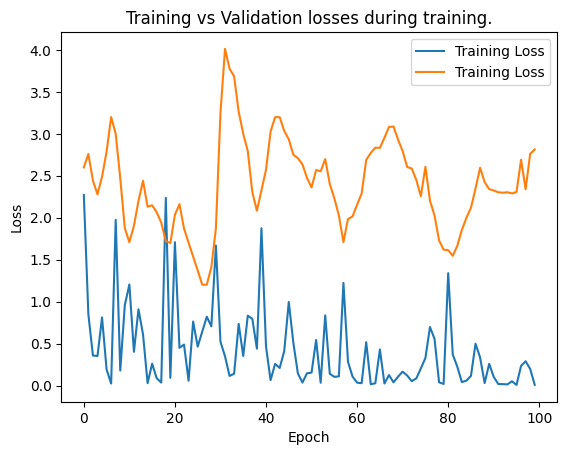

Classification report
              precision    recall  f1-score   support

   automotor       0.50      0.50      0.50         2
  hypermotor       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4



In [7]:
model, preprocess = create_video_ResNet(n_classes=len(label_dict), device=DEVICE)

model.requires_grad = False
model.fc.requires_grad = True

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=TRANSFER_LEARNING_RATE)

train_loss, val_loss = train_silence(model=model, train_dataset=train_dataset, val_dataset=val_dataset, preprocess=preprocess, device=DEVICE, 
                                     criterion=criterion, optimizer=optimizer, epochs=EPOCHS, num_classes=len(label_dict), best_model_path=BEST_MODEL_PATH)

# load the best weights.
model.load_state_dict(torch.load(BEST_MODEL_PATH))

y_pred, y = get_predictions(model=model, dataloader=test_dataset, preprocess=preprocess, device=DEVICE)

plot_losses(train_loss, val_loss, 3)
calculate_metrics(y, y_pred, labels=[v for k,v in label_dict.items()])

## Attempt 4 - Modified Dataset

In [6]:
BASE_PATH = "../../Dataset_cropped/"
BEST_MODEL_PATH = os.path.join(os.getcwd(), "best_model5.pth")
EPOCHS = 100
BATCH_SIZE = 1
TRANSFER_LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For M1 mac processors.
# DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [7]:
train_dataset, val_dataset, test_dataset, label_dict = get_data_split(base_path=BASE_PATH, batch_size=BATCH_SIZE, seq_lenght=60, pts_unit="sec", num_workers=4)


10
4
4


Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to C:\Users\BRAIN_user/.cache\torch\hub\checkpoints\r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [01:13<00:00, 1.81MB/s] 
[loss: 0.0037 - val_loss: 1.013 | Train accuracy: 1.0 - Val accuracy: 0.5]: 100%|██████████| 100/100 [11:20:46<00:00, 408.46s/it]  
100%|██████████| 4/4 [01:24<00:00, 21.24s/it]


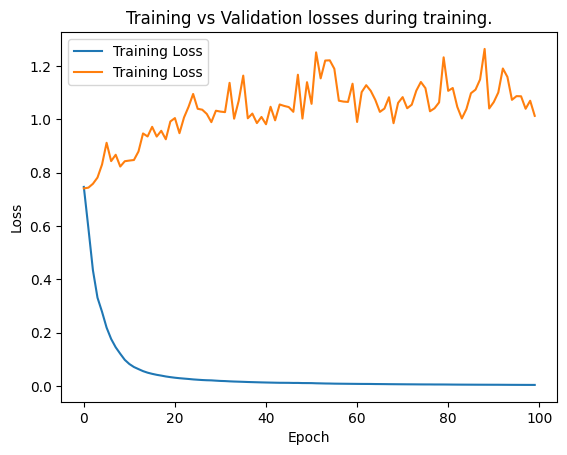

Classification report
              precision    recall  f1-score   support

   automotor       0.00      0.00      0.00         2
  hypermotor       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



c:\Users\BRAIN_user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\BRAIN_user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\BRAIN_user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [8]:
model, preprocess = create_video_ResNet(n_classes=len(label_dict), device=DEVICE)

model.requires_grad = False
model.fc.requires_grad = True

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=TRANSFER_LEARNING_RATE)

train_loss, val_loss = train_silence(model=model, train_dataset=train_dataset, val_dataset=val_dataset, preprocess=preprocess, device=DEVICE, 
                                     criterion=criterion, optimizer=optimizer, epochs=EPOCHS, num_classes=len(label_dict), best_model_path=BEST_MODEL_PATH)

# load the best weights.
model.load_state_dict(torch.load(BEST_MODEL_PATH))

y_pred, y = get_predictions(model=model, dataloader=test_dataset, preprocess=preprocess, device=DEVICE)

plot_losses(train_loss, val_loss,4)
calculate_metrics(y, y_pred, labels=[v for k,v in label_dict.items()])

## Atempt 5

In [9]:
BASE_PATH = "../../Dataset_cropped/"
BEST_MODEL_PATH = os.path.join(os.getcwd(), "best_model6.pth")
EPOCHS = 100
BATCH_SIZE = 1
TRANSFER_LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For M1 mac processors.
# DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [10]:
train_dataset, val_dataset, test_dataset, label_dict = get_data_split(base_path=BASE_PATH, batch_size=BATCH_SIZE, seq_lenght=90, pts_unit="sec", num_workers=4)


10
4
4


[loss: 0.0036 - val_loss: 0.8057 | Train accuracy: 1.0 - Val accuracy: 0.25]: 100%|██████████| 100/100 [21:47:00<00:00, 784.21s/it]  
100%|██████████| 4/4 [03:28<00:00, 52.24s/it] 


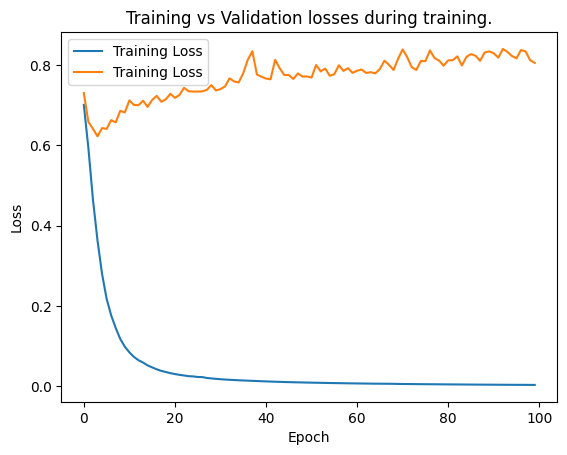

Classification report
              precision    recall  f1-score   support

   automotor       0.00      0.00      0.00         2
  hypermotor       0.33      0.50      0.40         2

    accuracy                           0.25         4
   macro avg       0.17      0.25      0.20         4
weighted avg       0.17      0.25      0.20         4



In [11]:
model, preprocess = create_video_ResNet(n_classes=len(label_dict), device=DEVICE)

model.requires_grad = False
model.fc.requires_grad = True

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=TRANSFER_LEARNING_RATE)

train_loss, val_loss = train_silence(model=model, train_dataset=train_dataset, val_dataset=val_dataset, preprocess=preprocess, device=DEVICE, 
                                     criterion=criterion, optimizer=optimizer, epochs=EPOCHS, num_classes=len(label_dict), best_model_path=BEST_MODEL_PATH)

# load the best weights.
model.load_state_dict(torch.load(BEST_MODEL_PATH))

y_pred, y = get_predictions(model=model, dataloader=test_dataset, preprocess=preprocess, device=DEVICE)

plot_losses(train_loss, val_loss,4)
calculate_metrics(y, y_pred, labels=[v for k,v in label_dict.items()])